In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import IFrame
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import mean_squared_error as MSE, recall_score, make_scorer
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score,roc_curve,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score, recall_score
import random
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro, kstest
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
#import scikitplot as skplt
from imblearn.over_sampling import SMOTE,SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import optuna

plt.rc('figure',figsize=(18,9))

# Summary of problem and results
We are given data regarding roughly 10,000 credit card customers. Roughly 15% of these customers have closed their cards ("attrited"), and our task is to build a model that can predict whether a given customer will attrit. As we discuss in the body of the notebook, we are particularly interested in maximizing the recall, or equivalently minimizing the number of false negatives.

In this notebook, we:
- Perform **exploratory data analysis**, including data visualization and hypothesis testing.
- Evaluate multiple machine learning models to see which is best-suited for the task at hand. Results from **cross-validation** lead us to select `RandomForestClassifier` and `GradientBoostingClassifer` as our models.
- **Tune hyperparameters** for the models we selected using **Bayesian Optimization with `Optuna`**. With tuned hyperparameters, we are able to train models with **recall of 81% and 92%, respectively**.
- Evaluate methods including class weights, SMOTENC, and undersampling to treat **class imbalance** in the problem. Using these methods, we are able to train a **`GradientBoostingClassifier` to 96% recall**.

# Table of contents



* [Explanation of features](#chapter1)
  * [Closer Look](#section_1_1)
* [Exploratory data analysis](#chapter2)
  * [Dealing with missing values](#section_2_1)
  * [Cross field validation](#section_2_2)
  * [Data visualization](#section_2_3)
  * [Data pre-processing](#chapter3)
     * [Encoding of Categorical Features](#section_3_1)
     * [Pearson and Spearman correlations](#section_3_2)
     * [Statistical Tests](#section_3_3)
* [Multiple model evaluation](#chapter4)
* [Useful functions](#chapter5)
* [Machine Learning Models](#ML)
  * [Random Forest Classifier](#RFC)
    * [Hyperparameter Tuning for Random Forest Classifier](#HTRFC)
    * [Random Forest model](#RFM)
  * [Gradient Boosting Classifier](#GBC)
    * [Hyperparameter Tuning for Gradient Boosting Classifier](#HTGBC)
    * [Gradient Boosting model](#GBM)
  * [Treating Class Imbalance](#TCI)
    * [Random Forest Classifier](#CI_RFC)
      * [Class Weight](#CW1)
      * [Undersampling](#UNDER1)
      * [SMOTENC](#SMOTENC1)
    * [Gradient Boosting Classifier](#CI_GBC)
      * [Undersampling](#UNDER2)
      * [SMOTENC](#SMOTENC2)

# Explanation of features <a id="chapter1"></a>


 - `CLIENTNUM` : Client number. Unique identifier for the customer holding the account
 - `Attrition_Flag` : Internal event (customer activity) variable - if the account is closed then 1 else 0
 - `Customer_Age` : Demographic variable - Customer's Age in Years
 - `Gender` : Demographic variable - M=Male, F=Female
 - `Dependent_count` : Demographic variable - Number of dependents
 - `Education_Level` : Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
 - `Marital_Status` : Demographic variable - Married, Single, Divorced, Unknown
 - `Income_Category` : Demographic variable - Annual Income Category of the account holder (< 40K, 40K - 60K, 60K - 80K, 80K-120K, >)
 - `Card_Category` : Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
 - `Months_on_book` : Period of relationship with bank
 - `Total_Relationship_Count` : Total no. of products held by the customer
 - `Months_Inactive_12_mon` : No. of months inactive in the last 12 months
 - `Contacts_Count_12_mon` : No. of Contacts in the last 12 months 
 - `Credit_Limit` : Credit Limit on the Credit Card
 - `Total_Revolving_Bal` : Total Revolving Balance on the Credit Card
 - `Avg_Open_To_Buy` : Open to Buy Credit Line (Average of last 12 months) (The difference between the credit limit assigned to a cardholder account and the present balance on the account.)
 - `Total_Amt_Chng_Q4_Q1` : Change in Transaction Amount (Q4 over Q1)
 - `Total_Trans_Amt` : Total Transaction Amount (Last 12 months)
 - `Total_Trans_Ct` : Total Transaction Count (Last 12 months)
 - `Total_Ct_Chng_Q4_Q1` : Change in Transaction Count (Q4 over Q1)
 - `Avg_Utilization_Ratio` : Average Card Utilization Ratio


## Closer Look <a name="section_1_1"></a>
Some of the features of the dataset deserve extra clarification.

#### 1. `Total_Revolving_Bal`
Total revolving balance is the outstanding balance of a credit card at the end of the billing cycle. In other words, the money the credit card holder owes.

**Implication**: A high total revolving balance might negatively affect credit score.

#### 2. `Avg_Open_To_Buy`
Average open to buy is the amount of available credit. In other words, the remaining credit that has not been used. 

**Implication**: A high average open to buy can positively affect credit score.

#### 3. `Total_Amt_Chng_Q4_Q1`
The change in total transaction amount (Q4 over Q1) is the difference between the amount spent in the fourth quarter (Q4) over the amount spent in the first quarter (Q1). Here it is defined as the fraction Q4/Q1.

**Implication**: When the fraction is less than 1, it means that the amount spent in Q4 is less than Q1 and when it is bigger than 1 the amount spent in Q4 is more than Q1.

#### 4. `Total_Ct_Chng_Q4_Q1`
This metric represents the change in the number of transactions between Q4 and Q1.  Here it is defined as the fraction Q4/Q1.

**Implication**: Again when the fraction is less than 1, it means that the number of transactions in Q4 is less than Q1 and when it is bigger than 1 the number of transactions in Q4 is more than Q1.

#### 5. `Total_Trans_Amt`
This metric represents the total amount of money spent during the last 12 months.

**Implication**: Higher transaction amounts may indicate more frequent or larger purchases (which potentially may increase rewards or cashback benefits.)

#### 6. `Total_Trans_Ct`
Similar to the previous one, this metric captures the total number of transactions during the last 12 months.

**Implication**: Higher transaction count indicates a more active use of the credit card (which potentially may increase rewards or cashback benefits.)

#### 7. `Avg_Utilization_Ratio`
This metric indicates how much of the available credit limit is being used on average. It's formula is:
$$
  \text{Avg Utilization Ratio} = \left(\frac{\text{Total Revolving Balance}}{\text{Credit Limit}}\right)
  $$

**Implication**: A low utilization ratio is considered a positive thing. According to [Experian](https://www.experian.com/blogs/ask-experian/credit-education/score-basics/credit-utilization-rate/) and [myFICO](https://www.myfico.com/credit-education/blog/credit-utilization-be) one should aim to keep the utilization ratio below 30% to maintain a higher credit score.

# Exploratory data analysis  <a id="chapter2"></a>

In this section perform initial exploration of the data. We check for missing values, perform cross field validation, visualize the data, encode the categorical features, plot the Spearman correlation heatmap, and perform hypothesis testing.

In [4]:
df=pd.read_csv("BankChurners.csv") #Load the dataset

In [5]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [6]:
df.drop(["CLIENTNUM","Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2","Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1"],axis=1, inplace=True);

In [7]:
df.shape

(10127, 20)

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

As we can see, our dataset has a mix of numerical and categorical features. 

In [9]:
df.isna().sum() #Checking for missing values

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

It looks as though we have no missing values, which is very convenient. However, there are many values labeled as "Unknown", which is essentially equivalent to missing.

In [10]:
df.isin(["Unknown"]).sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [12]:
print("The percentage of Unknown values in Education_Level is ",df["Education_Level"].isin(["Unknown"]).sum()*100/df.shape[0],"%")
print("The percentage of Unknown values in Marital_Status is ",df["Marital_Status"].isin(["Unknown"]).sum()*100/df.shape[0],"%")
print("The percentage of Unknown values in Income_Category is ",df["Income_Category"].isin(["Unknown"]).sum()*100/df.shape[0],"%")

The percentage of Unknown values in Education_Level is  14.999506270366348 %
The percentage of Unknown values in Marital_Status is  7.3960699121161255 %
The percentage of Unknown values in Income_Category is  10.980547052434087 %


These percentages are pretty high. Usually the cutoff for throwing away missing values is around 5%. So, in our case we would be losing a lot of valuable information. For this analysis, we will treat "Unknown" as another category.

## Cross Field Validation <a id="section_2_2"></a>

To ensure that our dataset is consistent, we can perform the following check:

The equation for the `Avg_Utilization_Ratio` is defined as:
$$
  \text{Avg Utilization Ratio} = \left(\frac{\text{Total Revolving Balance}}{\text{Credit Limit}}\right).
  $$

To validate this relationship, we can create a new column in our dataframe that computes the ratio `Total_Revolving_Bal`/`Credit_Limit`. We can then compare this new column with the existing `Avg_Utilization_Ratio` column. If the dataset is consistent, the values in these two columns should be nearly identical, within a small margin of error (e.g., due to rounding).

This check helps ensure the integrity and correctness of the data.

In [13]:
df["Avg_Utilization_Ratio_CFV"]=round((df["Total_Revolving_Bal"]/df["Credit_Limit"]),3)

In [14]:
df[["Avg_Utilization_Ratio_CFV","Avg_Utilization_Ratio"]]

,Avg_Utilization_Ratio_CFV,Avg_Utilization_Ratio
0,0.061,0.061
1,0.105,0.105
2,0.000,0.000
3,0.760,0.760
4,0.000,0.000
...,...,...
10122,0.462,0.462
10123,0.511,0.511
10124,0.000,0.000
10125,0.000,0.000


In [15]:
identical_elements = (df['Avg_Utilization_Ratio_CFV'] == df['Avg_Utilization_Ratio']).all()
print(f"Are the columns identical? {identical_elements}")

Are the columns identical? True


The values in the two columns match exactly up to the third decimal place. Therefore, we can conclude that our data is accurate. We can now drop the new column, as it has fulfilled its purpose.

In [16]:
df.drop(columns=['Avg_Utilization_Ratio_CFV'],inplace=True)

## Data Visualization  <a id="section_2_3"></a>

We first plot all the numerical features.

In [17]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


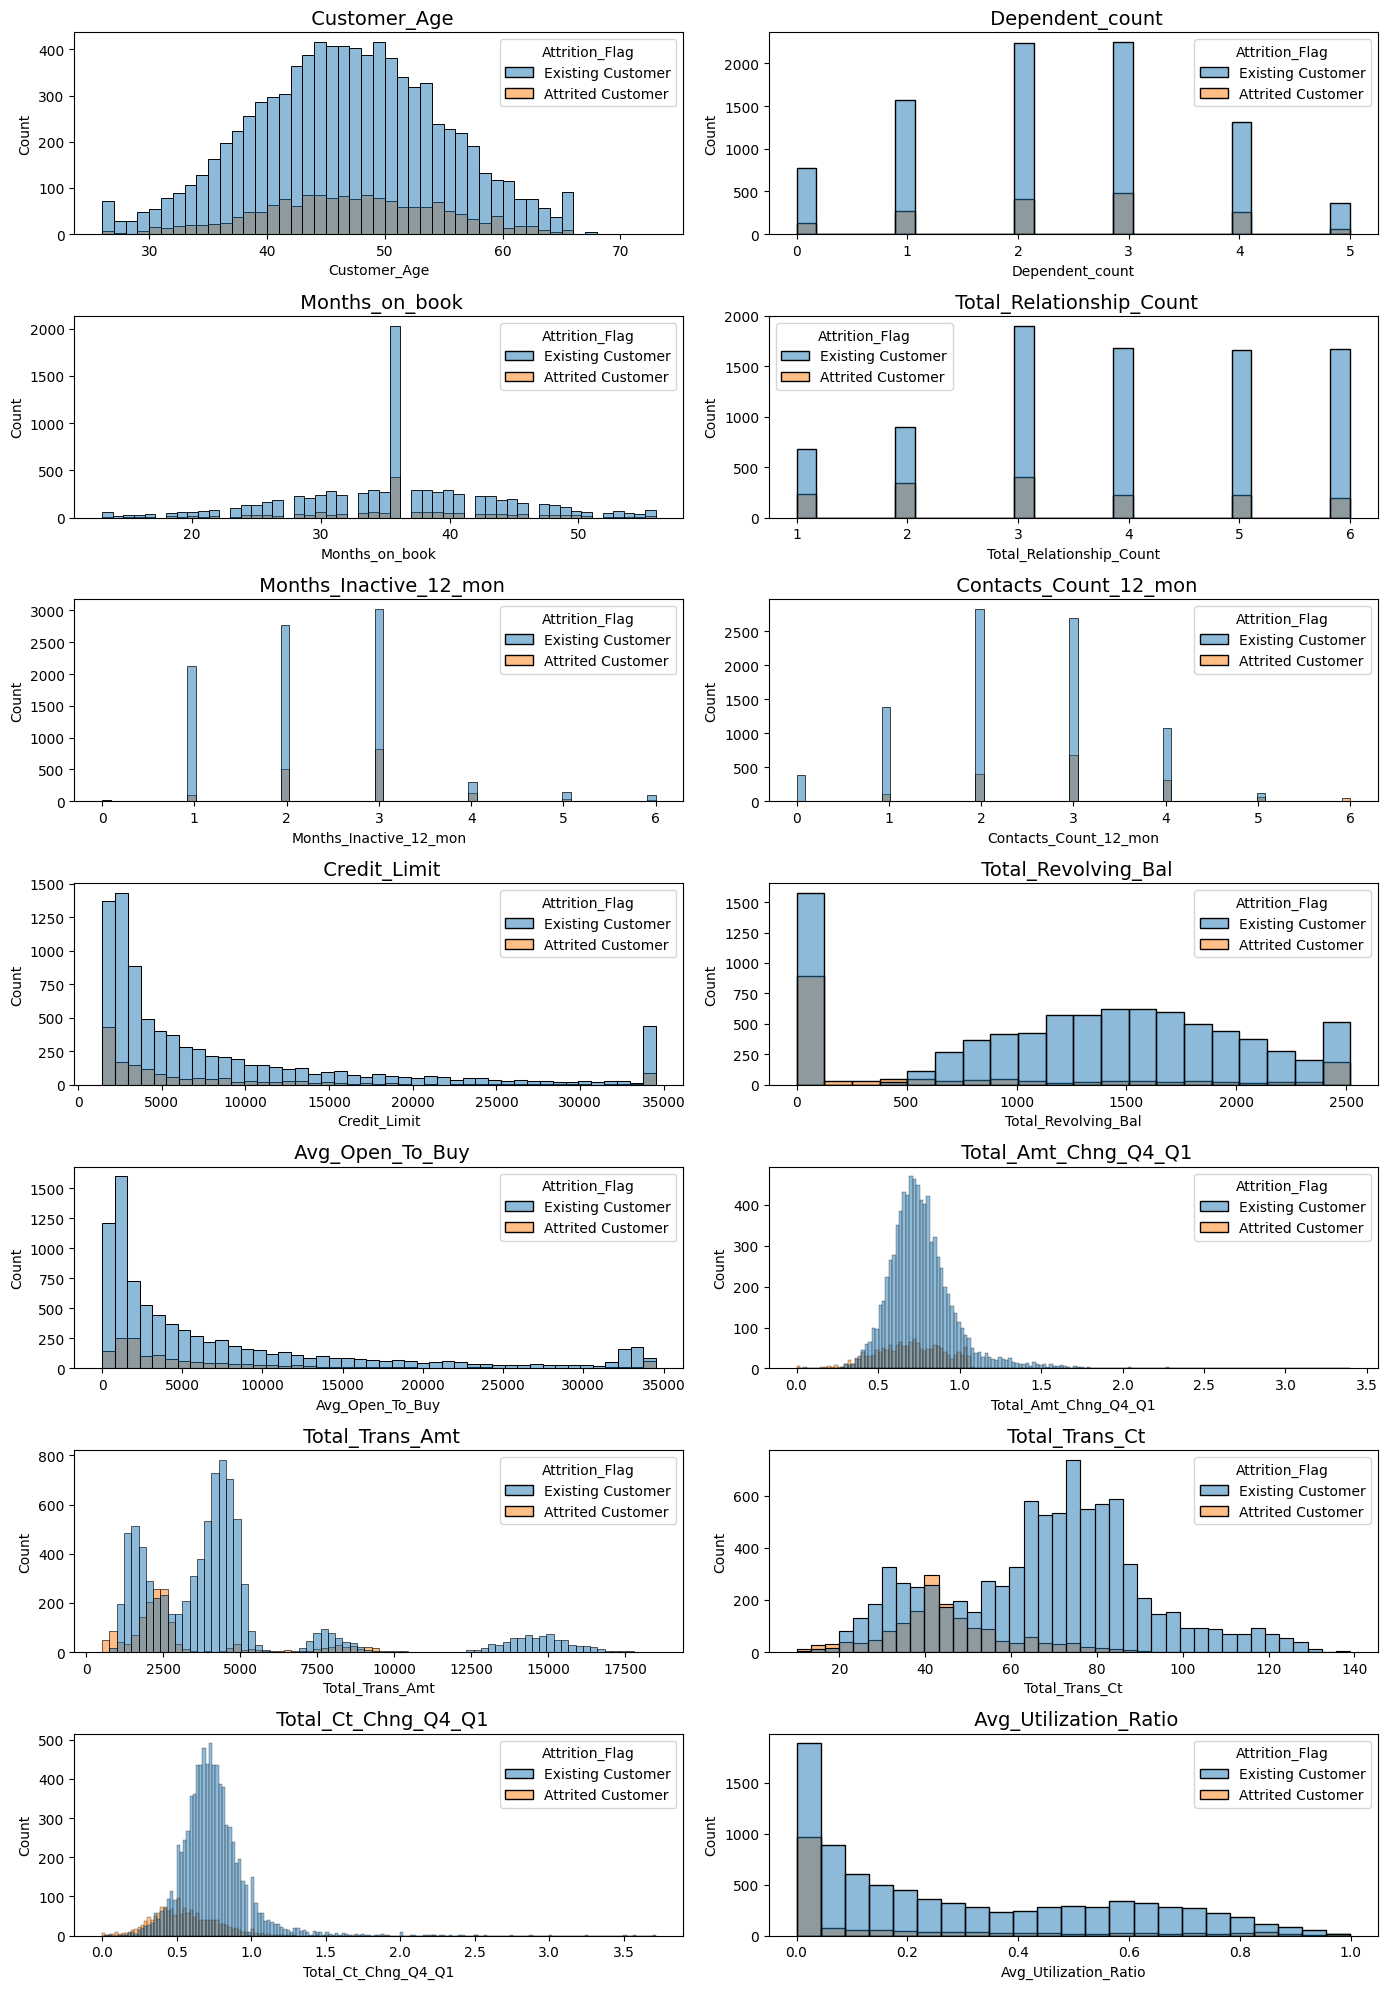

In [18]:
#Numerical features
fig, axes = plt.subplots(7, 2, figsize=(14,20))

for i, column in enumerate(df.select_dtypes(include=['int', 'float']).columns):
    row = i // 2  # Calculate the row for the subplot
    col = i % 2   # Calculate the column for the subplot
    g=sns.histplot(data=df, x=column, ax=axes[row, col],hue="Attrition_Flag",alpha=0.5)
    ax=axes[row, col]
    ax.set_title(f' {column}', fontsize=14)
plt.tight_layout()
plt.show()

Some remarks on interesting features:

#### `Months_on_book`
There is a huge peak at 36 months. A reasonable guess is that this has to do with dataset selection. The peak is present for both attrited customers and existing customers. Perhaps the bank had a special credit card offer 3 years ago, so many people signed up then.

#### `Credit_Limit`
The maximum credit limit is just under $35000. There is a bump in the histogram there, which suggests some data clipping, or that 35000 is the maximum limit offered by the bank.

#### `Total_Revolving_Bal`
There are many accounts with near zero revolving balance, meaning the customers are timely in paying off their balances, or they are not using their cards. Another interesting feature of this plot is that in the neighborhood of approximately $125-500 there are 105 attrited and 20 existing customers, as can be seen in the code below:

In [20]:
df[(df["Total_Revolving_Bal"]>125)&(df["Total_Revolving_Bal"]<500)]["Attrition_Flag"].value_counts()

Attrition_Flag
Attrited Customer    105
Existing Customer     20
Name: count, dtype: int64

This is a peculiar effect and the explanation as to why is not obvious. Finally, the highest amount of revolving balances is approximately $2500. Taking into account that there exist customers that have credit limits way higher than this value (up to ~35000) it seems unlikely that no one has debt higher than this. This suggests that the data might have been selected to only include revolving balances up to this threshold.

#### `Total_Amt_Chng_Q4_Q1`
The distribution of this variable for existing customers has a long tail on the right side that is not present for attrited customers.

#### `Total_Trans_Amt`
The distribution is visually multimodal, with different mode populations for existings vs. attrited customers. 

#### `Total_Trans_Ct`
As can be expected, this distribution is also multimodal. The attrited customers seem to populate a single mode with lower transaction counts than the existing customers. 

#### `Total_Ct_Chng_Q4_Q1`
Both distributions seem approximately normal, with the mode for the attrited customers shifter to the left compared to the existing customers. While some existing customers used their cards more in Q4 than Q1, this is rare for attrited customers.

Next we examine the categorical features.

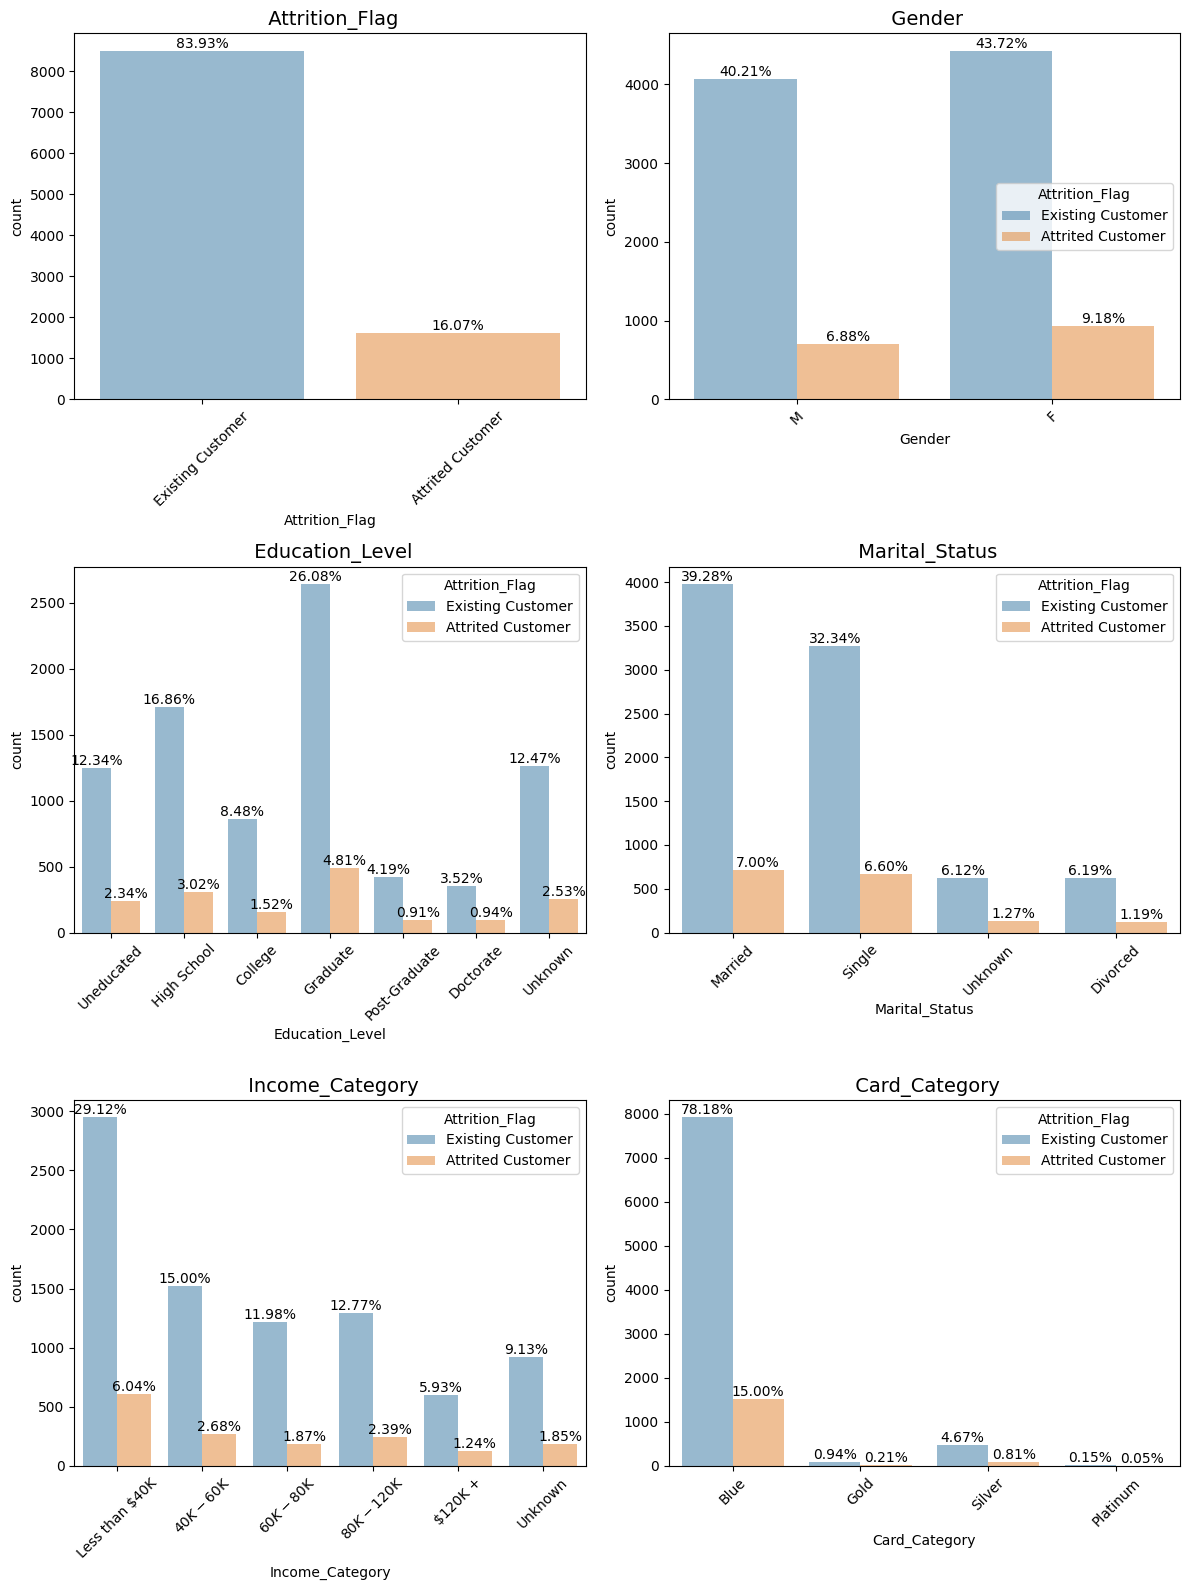

In [21]:
# Categorical features
category_order_income=["Less than $40K","$40K - $60K","$60K - $80K","$80K - $120K","$120K +","Unknown"]
category_order_education=["Uneducated","High School","College","Graduate","Post-Graduate","Doctorate","Unknown"]

fig, axes = plt.subplots(3, 2, figsize=(12, 16))

for i, column in enumerate(df.select_dtypes('object').columns):
    row = i // 2  # Calculate the row for the subplot
    col = i % 2   # Calculate the column for the subplot
    if column=="Education_Level":
    # Create the count plot
        ax = sns.countplot(data=df, x=column, ax=axes[row, col], hue="Attrition_Flag",order=category_order_education,alpha=0.5)
    elif column=="Income_Category":
        ax = sns.countplot(data=df, x=column, ax=axes[row, col], hue="Attrition_Flag",order=category_order_income,alpha=0.5)
    else:
        ax = sns.countplot(data=df, x=column, ax=axes[row, col], hue="Attrition_Flag",alpha=0.5)


    # Calculate the total counts for percentages
    total = len(df)
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate if height is greater than 0
            percentage = height / total * 100  # Calculate percentage
            ax.annotate(f'{percentage:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')


    ax.set_title(f' {column}', fontsize=14)
    ax.tick_params(axis='x', rotation=45)   # Rotate x labels

plt.tight_layout()
plt.show()

In the plots the percentages shown represent percentages over the total population. Overall the distributions of the existing and the attrited customers are visually similar. One thing to notice is that there are some features with very low numbers of observations such as card category=Platinum:

In [22]:
df.groupby("Attrition_Flag")["Card_Category"].value_counts()

Attrition_Flag     Card_Category
Attrited Customer  Blue             1519
                   Silver             82
                   Gold               21
                   Platinum            5
Existing Customer  Blue             7917
                   Silver            473
                   Gold               95
                   Platinum           15
Name: count, dtype: int64

As can be seen from above there are only 20 Platinum card holders, with 15 existing and only 5 attrited. 

At this point, we are going to create a copy of our dataframe `dfo`, that contains the categorical features as objects, because we are going to need it later in the analysis. In the original `df` we are going to encode the categorical variables in order to have a machine learning friendly dataframe.

In [23]:
dfo=df.copy(deep=True)

## Data Preprocessing <a id="chapter3"></a>

### Encoding of Categorical Features  <a id="section_3_1"></a>

Our dataset is a combination of both numerical and categorical features. The categorical features can be further split in ordinal, which have some meaningful order (`Education_Level`, `Income_Category`, `Card_Category`) and nominal, which do not (`Marital_Status` and `Gender`). When encoding we need to treat them differently.

In this instance we are going to **manually encode the ordinal features** and **one-hot encode the nominal ones**. Since the nominal features are only two and their respective values are also limited we do not create an unmanageable amount of new columns, which is a concern when using one-hot encoding.

In [24]:
Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4,
    'Unknown'        : 5}


Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3}


Attrition_Flag_map = {
    'Existing Customer' : 0,
    'Attrited Customer' : 1}

Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6}


df['Income_Category'] = df['Income_Category'].map(Income_Category_map)
df['Card_Category'] = df['Card_Category'].map(Card_Category_map)
df['Attrition_Flag'] = df['Attrition_Flag'].map(Attrition_Flag_map)
df['Education_Level'] = df['Education_Level'].map(Education_Level_map)

In [25]:
df=pd.get_dummies(df,columns=['Gender','Marital_Status'], dtype=int)

In [26]:
df.head()

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,0,45,3,1,2,0,39,5,1,3,...,1144,42,1.625,0.061,0,1,0,1,0,0
1,0,49,5,3,0,0,44,6,1,2,...,1291,33,3.714,0.105,1,0,0,0,1,0
2,0,51,3,3,3,0,36,4,1,0,...,1887,20,2.333,0.000,0,1,0,1,0,0
3,0,40,4,1,0,0,34,3,4,1,...,1171,20,2.333,0.760,1,0,0,0,0,1
4,0,40,3,0,2,0,21,5,1,0,...,816,28,2.500,0.000,0,1,0,1,0,0


As we can see above, all our datapoints are now in a numerical form. We can also take a look at their specific type below.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Dependent_count           10127 non-null  int64  
 3   Education_Level           10127 non-null  int64  
 4   Income_Category           10127 non-null  int64  
 5   Card_Category             10127 non-null  int64  
 6   Months_on_book            10127 non-null  int64  
 7   Total_Relationship_Count  10127 non-null  int64  
 8   Months_Inactive_12_mon    10127 non-null  int64  
 9   Contacts_Count_12_mon     10127 non-null  int64  
 10  Credit_Limit              10127 non-null  float64
 11  Total_Revolving_Bal       10127 non-null  int64  
 12  Avg_Open_To_Buy           10127 non-null  float64
 13  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 14  Total_

### Pearson and Spearman correlations  <a id="section_3_2"></a>

To assess feature correlations, Pearson or Spearman correlation coefficients can be used. The Pearson correlation measures linear relationships between continuous variables. However, its assumptions and applicability are still heavily debated, as highlighted in this
[article](https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx).

In contrast, the Spearman correlation coefficient is derived from the ranks of the values of each variable rather than their actual values. This approach makes it suitable for ordinal categorical variables. Additionally, the Spearman coefficient does not assume that the variables have linear relationships, which broadens its applicability compared to Pearson's method.


Some useful references for more intuition on the subject of Pearson and Spearman correlations:

- [Can I use Pearsons correlation with categorical variables](https://www.quora.com/Can-I-use-Pearsons-correlation-with-categorical-variables)
- [Lesson Explainer: Spearman’s Rank Correlation Coefficient](https://www.nagwa.com/en/explainers/412129796494/)

Our dataset consists of numerical (continuous and discrete) variables and encoded ordinal and nominal variables. Additionally, some of our variables exhibit non-linear relationships among each other. As an example, we can visualize the relationship between the "Total_Trans_Amt" and "Credit_Limit".

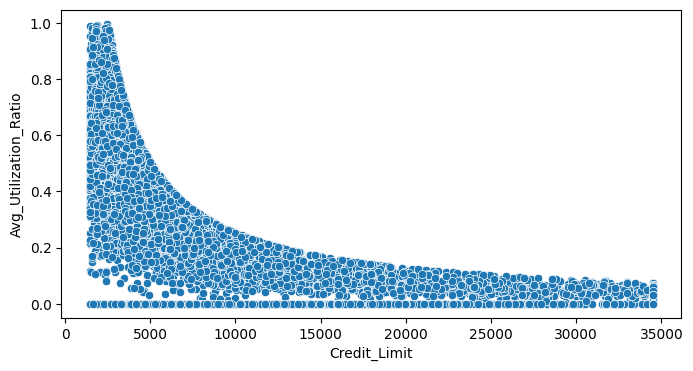

In [28]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df,x="Credit_Limit",y="Avg_Utilization_Ratio");

There seems to be an upper threshold that falls off as a power law. This is a consequence of the definition of the `Avg_Utilization_Ratio`:
$$
  \text{Avg Utilization Ratio} = \left(\frac{\text{Total Revolving Balance}}{\text{Credit Limit}}\right).
$$
In particular we noticed above that the dataset seems capped at roughly 2500 revolving balance, leading to a very sharp $1/x$ dependence for `Avg_Utilization_Ratio`.

Taking the above into account the most adequate option is to calculate the Spearman correlation heatmap, excluding the nominal data.

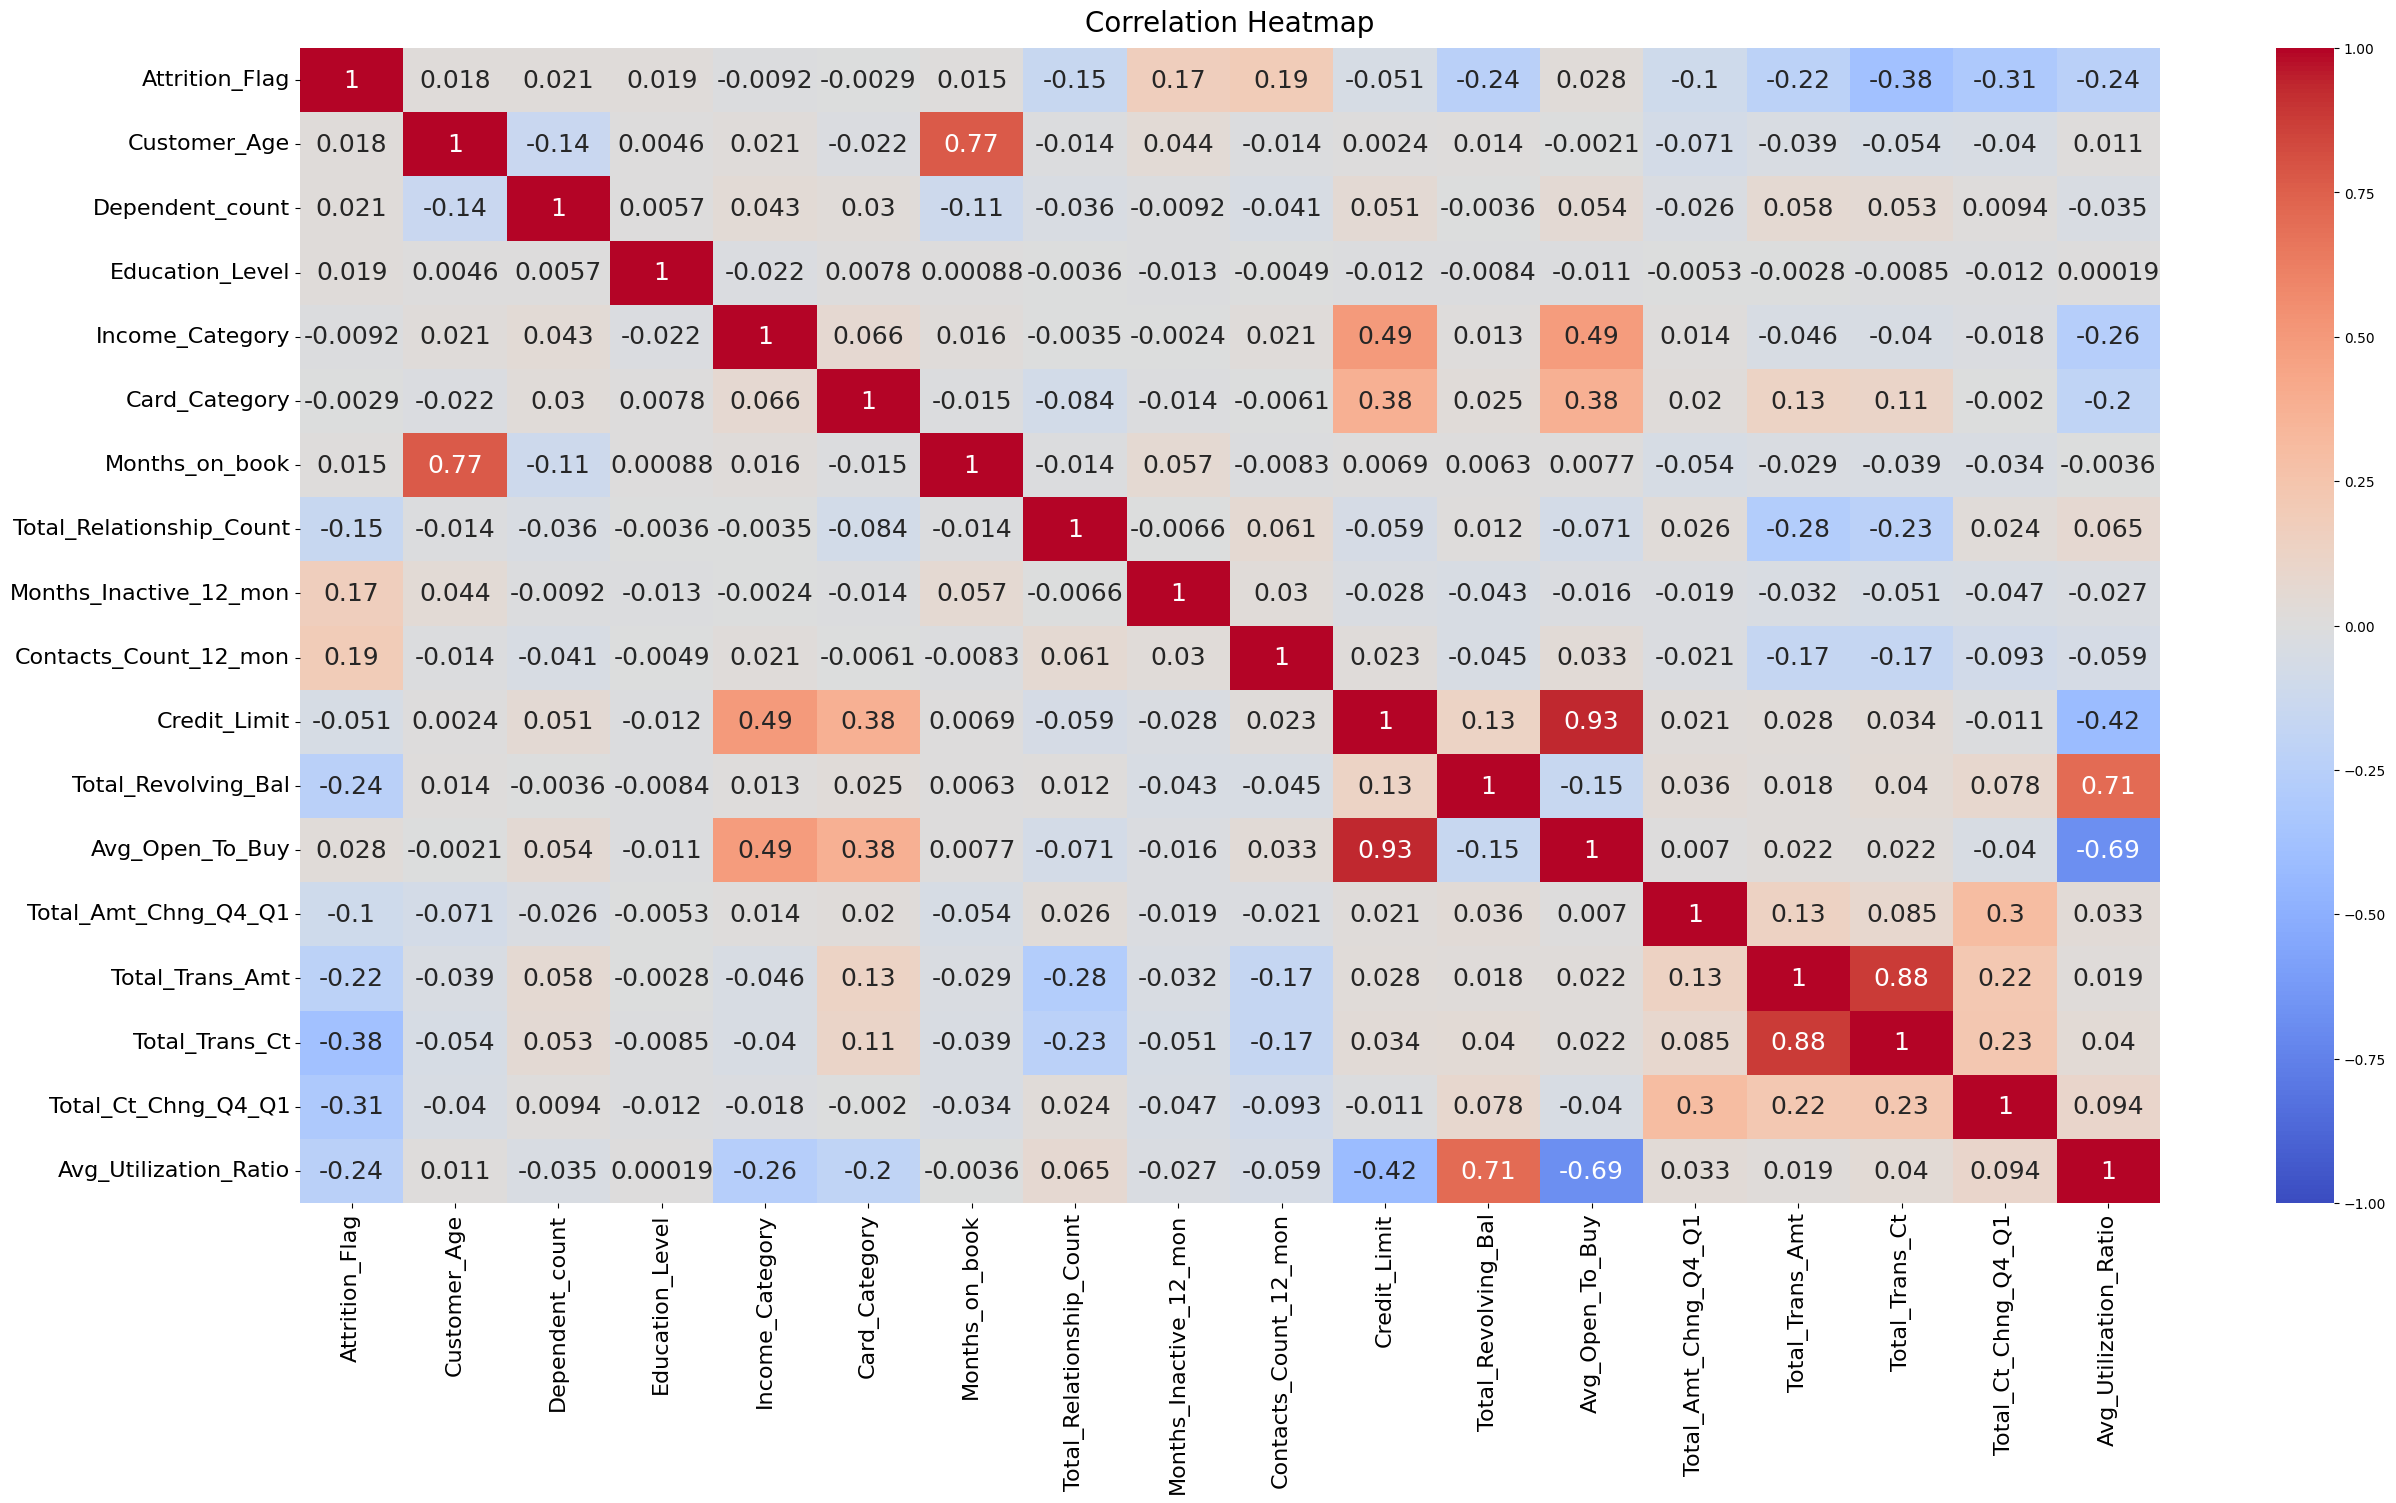

In [29]:
df_corr=df.drop(columns=['Gender_F','Gender_M','Marital_Status_Divorced','Marital_Status_Married','Marital_Status_Single', 'Marital_Status_Unknown'])

plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(df_corr.corr('spearman'), vmin=-1, vmax=1, annot=True, cmap="coolwarm",annot_kws={"size": 18})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)
heatmap.tick_params(axis='y', labelsize=16) 
heatmap.tick_params(axis='x', labelsize=16)

From the heatmap it is clear that none of the variables is very strongly correlated with the target variable "Attrition_Flag". However, there are some variables that are moderately correlated with "Attrition_Flag".

The variables showing a negative association with the target variable are:

- **Total_Trans_Ct** with coefficient **-0.38** (additionally correlated with **Total_Trans_Amt** with coefficient **+0.88**)
- **Total_Ct_Chng_Q4_Q1** with coefficient **-0.31** (additionally correlated with **Total_Amt_Chng_Q4_Q1** with coefficient **+0.30**)
- **Total_Revolving_Bal** with coefficient **-0.24** (additionally correlated with **Avg_Utilization_Ratio** with coefficient **+0.71**)
- **Avg_Utilization_Ratio** with coefficient **-0.24** (additionally correlated with **Total_Revolving_Bal** with coefficient **+0.71** and **Avg_Open_To_Buy**  with coefficient **-0.69**)

As a note, even though **Credit_Limit** does not see to be directly correlated with the target variable it is positively correlated with **Avg_Open_To_Buy** with coefficient **+0.93**. This is intuitive given the closely-linked definitions of these features.

The positively associated variables are:
- **Contacts_Count_12_mon** with coefficient **+0.19** (correlated with **Total_Trans_Amt** and **Total_Trans_Ct** with coefficient **-0.17**)
- **Months_inactive_112_mon** with coefficient **+0.17**


### Statistical Tests <a id="section_3_3"></a>

We first test for normality, then for association between various features and the attrition flag.

#### Normality tests

In section [Data Visualization](#section_2_3) we saw that many of our numerical features do not look normally distributed. Let's confirm our intuition by using the Kolmogorov-Smirnov test of normality (The Shapiro-Wilk for samples larger than 5000 can be inaccurate.) 

The  **Null Hypothesis (H0)** is that the **data is normally distributed**. We take our significance level to be $\alpha = 0.05$ for all tests.

In [33]:
categorical_features = [
        "Gender_F",
        "Gender_M",
        "Marital_Status_Divorced",
        "Marital_Status_Married",
        "Marital_Status_Single",
        "Marital_Status_Unknown",
        "Education_Level",
        "Income_Category",
        "Card_Category",
        "Attrition_Flag"]
numerical_features = df.drop(columns=categorical_features).columns.to_list()
dfn=df.drop(columns=categorical_features)

normality_results = {}

for column in numerical_features:
    ks_stat, ks_p = kstest(df[column].dropna(), 'norm', args=(dfn[column].mean(), dfn[column].std()))
    
    normality_results[column] = {'K-S P-Value': ks_p}

# Convert results to DataFrame for better visualization
normality_results_df = pd.DataFrame(normality_results).T
print(normality_results_df)

                            K-S P-Value
Customer_Age               2.234086e-07
Dependent_count           4.093025e-226
Months_on_book            1.966070e-145
Total_Relationship_Count  1.795582e-195
Months_Inactive_12_mon     0.000000e+00
Contacts_Count_12_mon     2.633382e-296
Credit_Limit               0.000000e+00
Total_Revolving_Bal       1.423165e-247
Avg_Open_To_Buy            0.000000e+00
Total_Amt_Chng_Q4_Q1       5.951957e-52
Total_Trans_Amt            0.000000e+00
Total_Trans_Ct             3.792646e-31
Total_Ct_Chng_Q4_Q1        5.057005e-62
Avg_Utilization_Ratio     4.038740e-225


If we trust the K-S test, the above results suggest that **none of our numerical variables is normally distributed**. This aligns with our visual analysis in section section [Data Visualization](#section_2_3), confirming the need for non-parametric tests.

We treat our numerical and categorical data separately. Our categorical data includes nominal variables like `Marital_Status` and `Gender`, and ordinal variables like `Education_Level`, `Income_Category`, and `Card_Category`. For all categorical data we are going to use the Chi-Square test of independence, which is appropriate for categorical variables. However, we are going to use a version of the dataframe that has all the categorical data as objects instead of the encoded one. The reason behind this choice is because our nominal variables are one-hot encoded and the Chi-Square test of independence does not work correctlyin this case. It expects data to be in a single column with distinct categories, rather than split across multiple columns, which is what happens with one-hot encoding.

#### Chi-square test of Independence for categorical features

The **Null Hypothesis (H0)** is: There is **no association between the variable `Attrition_Flag` and the categorical features** (`Gender`, `Marital_Status`, etc.). In other words, the attrition status is independent of the other variables. 


In [34]:
cat_features = [
        "Gender",
        "Marital_Status",
        "Education_Level",
        "Income_Category",
        "Card_Category"
]

chi_ind_cat={}
for feature in cat_features:
    contingency_table = pd.crosstab(dfo['Attrition_Flag'], dfo[feature])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_ind_cat[feature] = {
        'Chi-Ind P-Value': p}
chi_ind_cat_df=pd.DataFrame(chi_ind_cat).T
print(chi_ind_cat_df)

                 Chi-Ind P-Value
Gender                  0.000196
Marital_Status          0.108913
Education_Level         0.051489
Income_Category         0.025002
Card_Category           0.525238


The results suggest that we should **reject** the Null Hypothesis for
* Income_Category 
* Gender 

and accept it for the rest. 

#### Mann-Whitney test for numerical features

For all our numerical variables we are going to use the Mann-Whitney non-parametric test. As we mentioned before, the data is not normally distributed so we cannot use the usual parametric tests, such as t-tests, ANOVA, paired t-tests etc. 

The **Null Hypothesis** here is: The **distribution of the variable** (`Credit_Limit`,`Customer_Age` etc) **is the same across the two groups of** `Attrition_Flag` **(e.g., attrited vs. non-attrited customers)**. There is no significant difference in the variable between the two groups.

In [35]:
categorical_features = [
        "Gender_F",
        "Gender_M",
        "Marital_Status_Divorced",
        "Marital_Status_Married",
        "Marital_Status_Single",
        "Marital_Status_Unknown",
        "Education_Level",
        "Income_Category",
        "Card_Category"
    ]

X = df.drop("Attrition_Flag", axis=1)
y = df["Attrition_Flag"]

numerical_features = X.drop(columns=categorical_features).columns.to_list()

mannwhitneyu_p_values={}
for feature in numerical_features:
    stat, p = mannwhitneyu(df[df['Attrition_Flag'] == 0][feature], df[df['Attrition_Flag'] == 1][feature])
    mannwhitneyu_p_values[feature]={"Mann-Whitney p-value":p}
mannwhitneyu_p_values_df=pd.DataFrame(mannwhitneyu_p_values).T
print(mannwhitneyu_p_values_df)

                          Mann-Whitney p-value
Customer_Age                      7.809995e-02
Dependent_count                   3.472886e-02
Months_on_book                    1.236672e-01
Total_Relationship_Count          2.905717e-51
Months_Inactive_12_mon            5.423116e-67
Contacts_Count_12_mon             1.110888e-80
Credit_Limit                      3.007841e-07
Total_Revolving_Bal              1.915679e-129
Avg_Open_To_Buy                   5.652366e-03
Total_Amt_Chng_Q4_Q1              1.064474e-24
Total_Trans_Amt                  2.719009e-112
Total_Trans_Ct                    0.000000e+00
Total_Ct_Chng_Q4_Q1              1.908241e-216
Avg_Utilization_Ratio            2.869097e-129


As we can see from the table above, **we reject the null hypothesis for all the numerical variables**. It seems like there is a significant difference between the Attrited and Existing customer groups for all the numerical variables.

Our results suggest that we cannot very confidently leave some of the varibles out when building our machine learning model. Many of those variables seem relevant for the classification of clients.

# Multiple model evaluation <a id="chapter4"></a>

Having explored the data, we now turn to the prediction task. First we evaluate the performance of multiple classification models in order to decide which one we will use. First, a few words on methodology:

### Scaling the data

Our dataset contains both encoded categorical and numerical features. After we split the data  into training and test sets, for most machine learning models it is best to scale our numerical data. There are some exceptions, such as decision trees and random forests, which are not sensitive to the magnitude or scale of the features as they split data based on feature thresholds. However, for most models it is good practice. Moreover, encoded categorical features should not be scaled because they represent categories, not magnitudes. Scaling them could distort their meaning and relationships. Thus, we need to leave them intact. 

In order to achieve this, we build a pre-processor that uses `ColumnTransformer` to scale the numerical data and pass through the categorical data, leaving them untouched. Here, we chose to use `MinMaxScaler` instead of for example, `StandardScaler`, because the latter, as is stated in the [documentation](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html), might behave badly if the features are not normally distributed, which is true in our case. `MinMaxScaler` works well for non-normally distributed data because it doesn't assume any specific distribution of the data. It does not distort the data's underlying shape but rather compresses its scale. 

### Pipelines

Scikit-learn has a convenient class called `Pipeline`. The use of pipelines ensures that appropriate methods are applied to the corresponding subsets of the dataset. This is very important because different data types (such as categorical and numerical) require specific preprocessing steps, as we saw before. Additionally pipelines prevent data leakage. For example, it is important to scale only after splitting the data in train and test sets. Scaling the entire dataset before the split will result in information from the test set influencing the training set. This mean that we might get overly optimistic performance metrics but the model may not do well with new unseen data. When calling `pipeline.fit(X_train, y_train)` in the code below, it fits the pre-processor on `X_train` (scales numerical features and leaves categorical intact) and then trains the `RandomForestClassifier`. This happens separely for the test data, when we later call `pipeline.predict(X_test)`. The pipeline applies the same transformations to `X_test` before making predictions. It is clear that in this manner we avoid data leakage, so our model should be better at generalizing. These concepts will be useful throughout the rest of the analysis.

Concerning the multiple model evalaution, we perform cross validation in order to gain better insight for the models' performance.

In [36]:
# Create a models dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm='SAMME'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
}

results = [] 

# Loop through the models
for model_name, model in models.items():
    
    # Create a ColumnTransformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
        ],
        remainder='passthrough'  # Pass through any other columns unchanged
    )

    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Apply the preprocessor
        (model_name, model)  # Current model in the loop
    ])

    # Instantiate a KFold object
    kf = KFold(n_splits=6, random_state=47, shuffle=True)

    # Perform cross-validation
    cv_results = cross_val_score(pipeline, X, y, cv=kf)
    results.append(cv_results)

C:\Users\Alex\AppData\Local\Temp\ipykernel_205900\3813897323.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys())


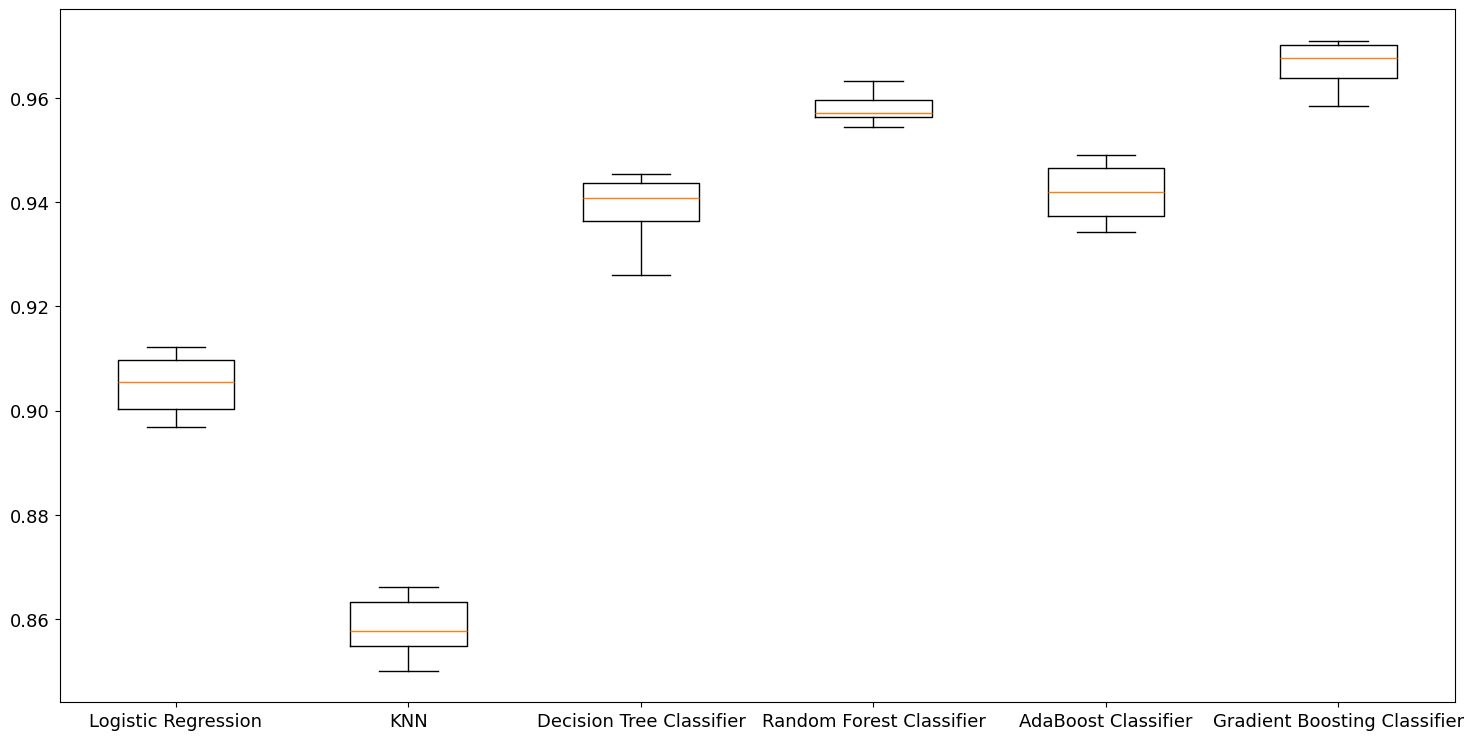

In [37]:
# Create a boxplot for results
plt.boxplot(results, labels=models.keys())
plt.xticks(fontsize = 13) 
plt.yticks(fontsize = 13) 
plt.axis
plt.show()

It looks like we have some clear winners: **Random Forest and Gradient Boosting**. We choose the focus the rest of our analysis on these two models.

# Utility Functions <a id="chapter5"></a>

Here we define some useful functions that we will need multiple times in the notebook. 

### Roc curve
A receiver operating characteristic (ROC) curve is a graph that shows how effectively a binary classifier distinguishes between true positives (TP) and false positives (FP). If the curve is a 45-degree line, it indicates that the model performs no better than random chance in classifying observations. The closer the curve is to the top-left corner, forming a "square-like" shape, the better the model is at distinguishing between TP and FP.

In [38]:
#Function to plot roc curves
def plot_roc_curve(y_test,y_pred_proba):
    '''Calculates roc_auc_score and plots roc auc curve'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure(figsize = (8,4))
    plt.plot(fpr, tpr, linestyle = '-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr, tpr, alpha = 0.5)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC AUC Curve having \n AUC score : {auc_score}')
    plt.show()

### Feature Importances
For tree-based models, the importance of a feature is measured by how much it improves the split at each node. Improvement is usually calculated using Gini impurity. The formula for Gini impurity is $$\text{Gini Impurity}=1-\sum_{i}(p_i)^2 ,$$ where $p_i$ represents the probability of an element belonging to a particular class. Its value ranges between zero and one, with zero the purest and one the most impure.

In [40]:
# Function to plot feature importances
def plot_n_print_feature_importances(model, df):
    '''Calculates feature importances, plots and prints them '''
    # Calculate feature importances
    X= df.drop("Attrition_Flag", axis=1)
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # Print feature importances
    print(importances)
    
    # Plot feature importances
    plt.figure(figsize=(8, 4))  # Adjust the size here (width, height)
    importances.plot(kind='bar')
    plt.title('Feature Importances')
    plt.ylabel('Importance Score')
    plt.show()

### Confusion matrix
The confusion matrix provides a very useful representation of model output on the test data. In our case it shows true positives (TP) in the bottom right, true negatives (TN) in the top left, false negatives (FN) in the bottom right and false positives (FP) in the top right.

In [41]:
# Function for confusion matrix
def plot_conf_matrix(model, y_test, y_pred):
    '''Calculates confusion matrix, plots and prints it'''
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 4))  # Adjust the figure size
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
                xticklabels=model.classes_, 
                yticklabels=model.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Machine Learning Models <a id="ML"></a>

### A few words on hyperparameter tuning
For any machine learning model, it is important to tune the model's hyperparameters to achieve optimal performance. Initially, we tried `GridSearch`, which exhaustively searches all possible combinations of hyperparameters within a predefined grid. We also used `RandomizedSearch`, which selects random samples of parameter combinations from the grid. However, both methods have a key limitation: they do not utilize information from prior evaluations to guide the search, which means they may explore unpromising areas of the parameter space. Additionally, for the problem at hand, both methods took too long to run, To address this, we turned to Bayesian optimization using Optuna, a more efficient and quicker approach.

### Bayesian optimization with Optuna
Bayesian optimization enhances hyperparameter tuning by utilizing prior results to identify promising configurations. It employs a surrogate function, a probabilistic model estimating the objective function (in our case, recall) based on previous observations. The next hyperparameter set is chosen using an acquisition function, balancing exploration (testing new configurations) and exploitation (focusing on successful areas). This iterative process continues until a set number of iterations is completed or a convergence criterion is met, making it a more efficient alternative to traditional methods like grid or random search.

Traditional Bayesian optimization uses a Gaussian Process as its surrogate function. However, Optuna uses Tree Parzen Estimators which utilize two separate surrogate functions. One surrogate function models the performance of hyperparameter configurations that are expected to perform well $P(x|\text{good})$, while the other models configurations expected to perform poorly $P(x|\text{bad})$. TPE (Tree-structured Parzen Estimator) chooses the most promising hyperparameter values by evaluating the ratio of the probability densities $$\frac{P(x|\text{good})}{P(x|\text{bad})}.$$

### Why do we optimize based on recall?
We chose to optimize the model with respect to recall because minimizing false negatives for attrition is our primary concern. In this context, a false negative occurs when a customer likely to churn (attrite) is incorrectly predicted to stay, which can be costly for banks. A [report](https://www.bcg.com/publications/2017/financial-institutions-marketing-sales-how-banks-close-back-door-attrition) by the consulting firm BCG, states that *"...that corporate banks annually lose 10% to 15% of gross revenues to attrition."* While it is essential for our model to distinguish between attrited and existing customers overall, the main priority is to minimize false negatives. This allows the bank to accurately identify customers at risk of attrition and implement effective retention strategies, ultimately reducing the financial impact of customer attrition.

## Random Forest Classifier <a id="RFC"></a>

### Hyperparameter Tuning for Random Forest Classifier <a id="HTRFC"></a>

In [43]:
categorical_features = [
        "Gender_F",
        "Gender_M",
        "Marital_Status_Divorced",
        "Marital_Status_Married",
        "Marital_Status_Single",
        "Marital_Status_Unknown",
        "Education_Level",
        "Income_Category",
        "Card_Category"
    ]

X = df.drop("Attrition_Flag", axis=1)
y = df["Attrition_Flag"]

# Identify numerical and categorical columns
numerical_features = X.drop(columns=categorical_features).columns.to_list()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)  
    max_depth = trial.suggest_int('max_depth', 1, 50)  
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
        ],
        remainder='passthrough'  # Pass through other columns unchanged
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('rf_model', RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            random_state=47))
    ])

    # Perform cross-validation on the training set to avoid overfitting
    recall_scorer = make_scorer(recall_score, pos_label=1)  # Recall scorer for positive class = 1
    cv_recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=recall_scorer)  # 5-fold CV

    # Return the average recall score from cross-validation
    return cv_recall_scores.mean()

In [193]:
# Create a study object to maximize recall
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best parameters and best recall score
print("Best Parameters:", study.best_params)
print("Best Score (Recall):", study.best_value)

[I 2024-10-03 17:44:31,362] A new study created in memory with name: no-name-50c7ad96-cdde-443f-a75a-8dd957bff428
[I 2024-10-03 17:45:05,587] Trial 0 finished with value: 0.7968371932250259 and parameters: {'n_estimators': 694, 'max_depth': 20, 'min_samples_split': 6}. Best is trial 0 with value: 0.7968371932250259.
[I 2024-10-03 17:45:09,913] Trial 1 finished with value: 0.7877347620693629 and parameters: {'n_estimators': 86, 'max_depth': 20, 'min_samples_split': 6}. Best is trial 0 with value: 0.7968371932250259.
[I 2024-10-03 17:45:58,321] Trial 2 finished with value: 0.7991128010139417 and parameters: {'n_estimators': 971, 'max_depth': 38, 'min_samples_split': 3}. Best is trial 2 with value: 0.7991128010139417.
[I 2024-10-03 17:46:34,195] Trial 3 finished with value: 0.7839526443138611 and parameters: {'n_estimators': 740, 'max_depth': 31, 'min_samples_split': 16}. Best is trial 2 with value: 0.7991128010139417.
[I 2024-10-03 17:47:18,378] Trial 4 finished with value: 0.79531916119

Best Parameters: {'n_estimators': 713, 'max_depth': 24, 'min_samples_split': 5}
Best Score (Recall): 0.8074547758958406
Final Recall on Test Set: 0.8084415584415584


### Random Forest model <a id="#RFM"></a>

We will now use the best parameters that we found from the hyperparameter tuning.

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1718
           1       0.93      0.81      0.86       308

    accuracy                           0.96      2026
   macro avg       0.95      0.90      0.92      2026
weighted avg       0.96      0.96      0.96      2026



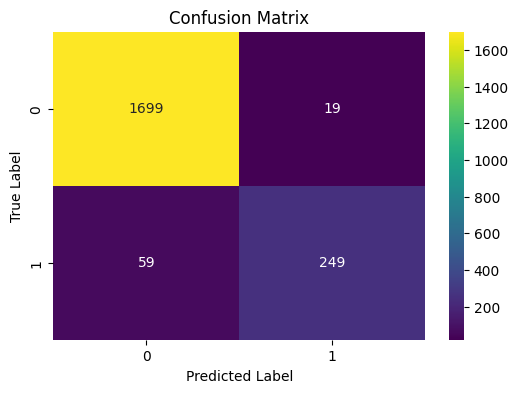

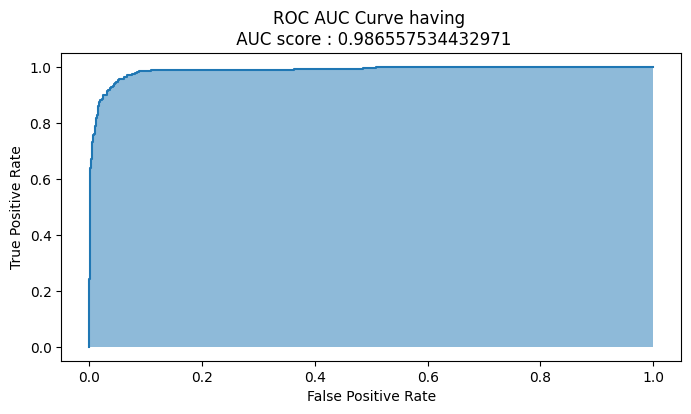

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

rf_model = RandomForestClassifier(random_state=47,n_estimators=713,max_depth=24,min_samples_split=5)

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply the preprocessor
    ('Random Forest Classifier', rf_model)  # model
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
y_pred_proba=pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
plot_conf_matrix(pipeline,y_test,y_pred)
#plot_n_print_feature_importances(pipeline.steps[1][1],df)
plot_roc_curve(y_test,y_pred_proba)

## Gradient Boosting Classifier <a id="GBC"></a>

### Hyperparameter Tuning for Gradient Boosting Classifier <a id="#HTGBC"></a>

In [46]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1500)  # Adjust range as necessary
    max_depth = trial.suggest_int('max_depth', 1, 30)  # Adjust range as necessary
    min_samples_split=trial.suggest_int('min_samples_split', 1, 20) 
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
        ],
        remainder='passthrough'  # Pass through any other columns unchanged
    )
   
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('Gradient Boosting Classifier', GradientBoostingClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            random_state=47))
    ])
    
     # Perform cross-validation on the training set to avoid overfitting
    recall_scorer = make_scorer(recall_score, pos_label=1)  # Recall scorer for positive class = 1
    cv_recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=recall_scorer)  # 5-fold CV

    # Return the average recall score from cross-validation
    return cv_recall_scores.mean()

In [197]:
# Create a study object
study = optuna.create_study(direction='maximize')  # maximize recall

# Optimize the objective function
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

# Print the best parameters
print("Best Parameters:", study.best_params)
print("Best Score (Recall):", study.best_value)

[I 2024-10-03 18:20:06,505] A new study created in memory with name: no-name-637df3b1-d1f2-424e-b570-16b1ca3925a1
[I 2024-10-03 18:21:16,190] Trial 0 finished with value: 0.7930637170180896 and parameters: {'n_estimators': 1088, 'max_depth': 23, 'min_samples_split': 7}. Best is trial 0 with value: 0.7930637170180896.
[I 2024-10-03 18:22:25,974] Trial 1 finished with value: 0.7877606867150593 and parameters: {'n_estimators': 925, 'max_depth': 18, 'min_samples_split': 8}. Best is trial 0 with value: 0.7930637170180896.
[I 2024-10-03 18:23:36,611] Trial 2 finished with value: 0.7930637170180896 and parameters: {'n_estimators': 1337, 'max_depth': 28, 'min_samples_split': 12}. Best is trial 0 with value: 0.7930637170180896.
[I 2024-10-03 18:23:49,703] Trial 3 finished with value: 0.8536957022698468 and parameters: {'n_estimators': 206, 'max_depth': 2, 'min_samples_split': 1}. Best is trial 3 with value: 0.8536957022698468.
[I 2024-10-03 18:24:56,378] Trial 4 finished with value: 0.793063717

Best Parameters: {'n_estimators': 1047, 'max_depth': 3, 'min_samples_split': 12}
Best Score (Recall): 0.8938731420670585


### Gradient Boosting model <a id="#GBM"></a>

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1718
           1       0.90      0.92      0.91       308

    accuracy                           0.97      2026
   macro avg       0.94      0.95      0.95      2026
weighted avg       0.97      0.97      0.97      2026



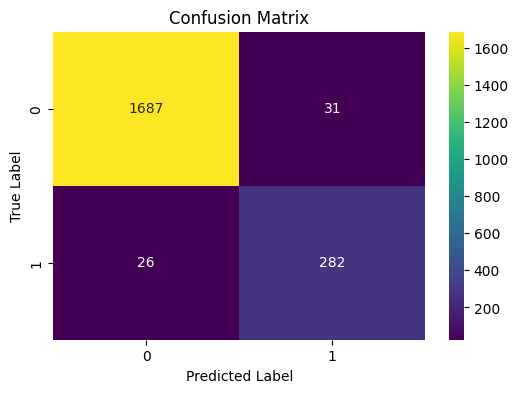

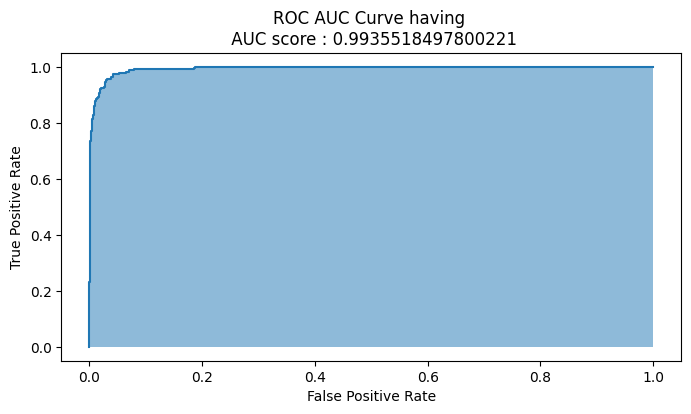

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

gb_model = GradientBoostingClassifier(n_estimators=1047,max_depth=3, min_samples_split=12, random_state=47)

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply the preprocessor
    ('Gradient Boosting Classifier', gb_model)  # model
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
y_pred_proba=pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
plot_conf_matrix(pipeline,y_test,y_pred)
#plot_n_print_feature_importances(pipeline.steps[1][1],df)
plot_roc_curve(y_test,y_pred_proba)

### Winner: Gradient Boosting Classifier

As is clear, from the various metrics, such as the classification reports, confusion matrices and roc curves, the model that **performs best is Gradient Boosting Classifier (GBC)**. Its recall is 0.92 in contrast to the Random Forest Classifier's (RFC), whose is 0.81. Naturally, false negatives are predicted more accurately for GBC than RFC, with their number being 26 and 59 and their roc_auc_scores approximately 0.9935 and 0.9866 respectively. From the models that we selected GBC is the winner.

### Class Imbalance Issue

One other aspect that can be addressed is class imbalance. Our two classes (attrited and existing customers) are quite imbalanced. Attrition comprises around 16% of our dataset. Imbalanced datasets may lead to models biased toward the majority class, leading to poor performance in predicting the minority class. Moreover, one can achieve a misleadingly high accuracy by simply predicting the majority class correctly, but still having a lot of false negatives. 

There are various techniques that can be used to address class imbalance. Our last model (GBC) performed quite well without applying any of these techniques, but it is worth taking a look on how these would perform. Some of the typical ones are adjusting the class weight (forcing the model to focus on the attrited class), undersampling the majority or oversampling the minority class in order to end up with a more balanced dataset. They all have their merits and shortcomings. For example, undersampling the majority leads to loss of potentially valuable information, oversampling with SMOTE leads sometimes to unnatural patterns in the minority data as it creates synthetic observables and class weight may overfit to the minority class.

In the next chapter, we use the class weight adjusting technique, undersampling and SMOTENC in our RFC and undersampling and SMOTENC for GBC (there is no way to adjust class weight in GBC). 

## Treating Class Imbalance  <a id="#TCI"></a>

### Random Forest Classifier <a id="#CI_RFC"></a>

#### Class Weight for Random Forest <a id="#CW1"></a>

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1718
           1       0.93      0.81      0.86       308

    accuracy                           0.96      2026
   macro avg       0.95      0.90      0.92      2026
weighted avg       0.96      0.96      0.96      2026



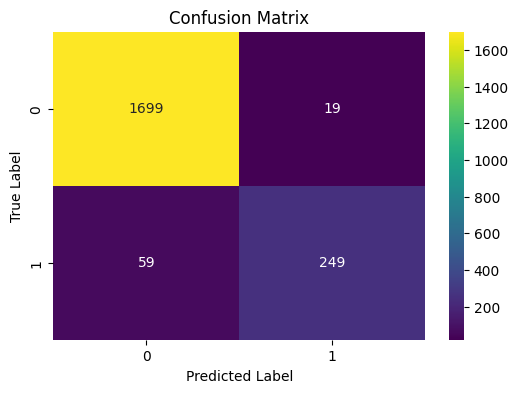

The roc_auc_score is  0.986557534432971


In [50]:
# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Step 2: Calculate class weights based on y_train
count_class_1 = y_train.value_counts()[0]
count_class_2 = y_train.value_counts()[1]
ratio = count_class_1 / count_class_2
class_weight = {0: 1, 1: ratio}

# Step 3: Define preprocessor and model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

rf_model = RandomForestClassifier(random_state=47,n_estimators=713,max_depth=24,min_samples_split=5)

# Step 4: Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Random Forest Classifier', rf_model)
])

# Step 5: Fit the pipeline
pipeline.fit(X_train, y_train)

# Step 6: Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Step 7: Evaluation
print(classification_report(y_test, y_pred))
plot_conf_matrix(pipeline, y_test, y_pred)
print("The roc_auc_score is ", roc_auc_score(y_test, y_pred_proba))


#### Comments for class weights
The idea behind class weight adjustment is that by assigning a higher weight to the minority class we are "forcing" the model to pay more attention to it, thus compensating for the fewer datapoints. The way we achieved this is by finding the number of 0-labeled observations (existing customers) in training set and the 1-labeled (attrited) and then use the ratio of the former over the latter as the weight of the attrited class. 

From the resulting classification report and confusion matrix it is evident that the adjustment we made had no impact. This is not entirely unexpected since Random Forests inherently manages class imbalance quite effectively without needing this adjustment. 

#### Undersampling for Random Forest <a id="#UNDER1"></a>

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1718
           1       0.71      0.94      0.81       308

    accuracy                           0.93      2026
   macro avg       0.85      0.94      0.88      2026
weighted avg       0.95      0.93      0.94      2026



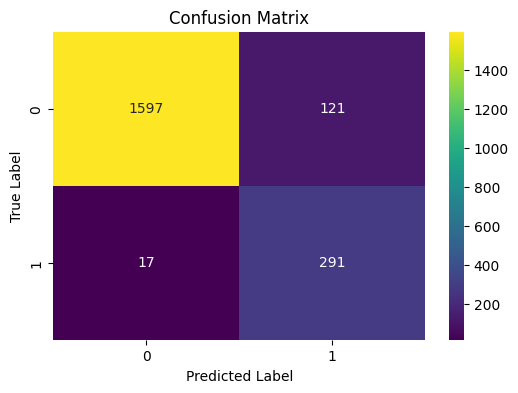

The roc_auc_score is  0.9829139137928429


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

#Apply undersampling
undersampler = RandomUnderSampler(random_state=47)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)


# Step 3: Define preprocessor and model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

rf_model = RandomForestClassifier(random_state=47,n_estimators=713,max_depth=24,min_samples_split=5)

# Step 4: Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('Random Forest Classifier', rf_model)
])

# Step 5: Fit the pipeline
pipeline.fit(X_train_under, y_train_under)

# Step 6: Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Step 7: Evaluation
print(classification_report(y_test, y_pred))
plot_conf_matrix(pipeline, y_test, y_pred)
print("The roc_auc_score is ", roc_auc_score(y_test, y_pred_proba))

#### Comments for Undersampling
The idea behind undersampling is to eliminate some observations from the majority class to create a more balanced dataset. Comparing the classification report and confusion matrix between the regular and undersampled cases reveals a significant improvement in recall, which skyrocketed from 0.81 to 0.94, while the number of false negatives decreased drastically from 59 to 17. This demonstrates a notable enhancement in the model’s ability to identify potential attritors. However, this improvement comes at a cost: the false positives have also increased, indicating that the bank may incorrectly flag some customers as likely to attrit when they will not. The decision regarding whether this model is suitable ultimately depends on the bank's priorities. They must weigh the importance of accurately identifying at-risk clients against the potential costs of increased false positives, which could lead to unnecessary retention efforts and resource allocation.

#### SMOTENC for Random Forest <a id="#SMOTENC1"></a>

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1718
           1       0.83      0.90      0.86       308

    accuracy                           0.96      2026
   macro avg       0.91      0.93      0.92      2026
weighted avg       0.96      0.96      0.96      2026



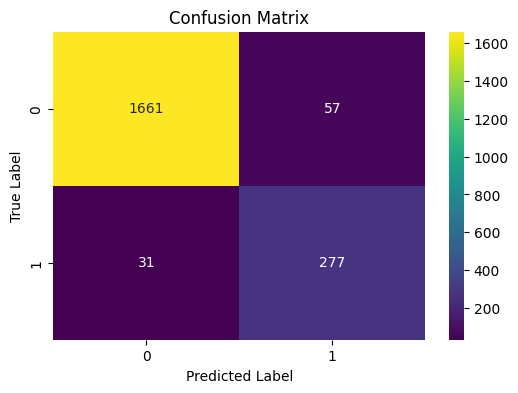

The roc_auc_score is  0.9854103986816444


In [52]:
categorical_feature_indices = [X.columns.get_loc(col) for col in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Step 2: Apply SMOTENC for oversampling
smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=47)
X_train_over, y_train_over = smote_nc.fit_resample(X_train, y_train)

# Step 3: Define preprocessor and model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

rf_model = RandomForestClassifier(random_state=47,n_estimators=713,max_depth=24,min_samples_split=5)

# Step 4: Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Random Forest Classifier', rf_model)
])

# Step 5: Fit the pipeline
pipeline.fit(X_train_over, y_train_over)

# Step 6: Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Step 7: Evaluation
print(classification_report(y_test, y_pred))
plot_conf_matrix(pipeline, y_test, y_pred)
print("The roc_auc_score is ", roc_auc_score(y_test, y_pred_proba))

#### Comments for SMOTENC
Last but not least, we used SMOTENC. SMOTENC creates synthetic data based on the observations in the minority class, thus balancing the dataset. Using SMOTENC improved the recall, going from 0.81 to 0.9. Moreover, the number of false negatives has decreased from 59 to 31, but the number of false positives increased from 19 to 57. 

### Gradient Boosting Classifier <a id="#CI_GBC"></a>

Ultimately, based on the models' performance Gradient Boosting Classifier seems like the better choice. Below we demonstrate what happens we undersample or use SMOTENC.

#### Undersampling <a id="#UNDER2"></a>

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1718
           1       0.79      0.96      0.86       308

    accuracy                           0.95      2026
   macro avg       0.89      0.96      0.92      2026
weighted avg       0.96      0.95      0.96      2026



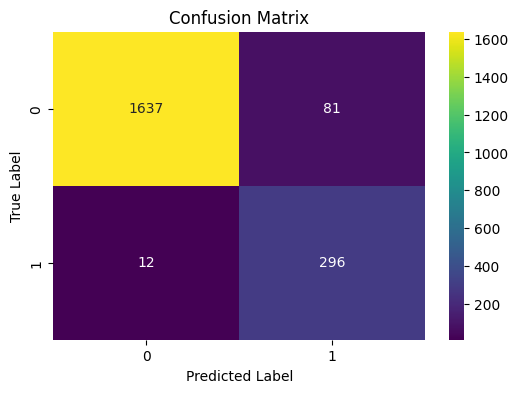

The roc_auc_score is  0.9915731823473384


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

#Apply undersampling
undersampler = RandomUnderSampler(random_state=47)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)


# Step 3: Define preprocessor and model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

gb_model = GradientBoostingClassifier(n_estimators=406,max_depth=3, min_samples_split=2, random_state=47)

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply the preprocessor
    ('Gradient Boosting Classifier', gb_model)  # model
])

pipeline.fit(X_train_under,y_train_under)
y_pred=pipeline.predict(X_test)
y_pred_proba=pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
plot_conf_matrix(pipeline,y_test,y_pred)
print("The roc_auc_score is ", roc_auc_score(y_test, y_pred_proba))

#### Comments on undersampling
The recall has improved, going from 0.92 to 0.96. The number of false negatives has also significantly decreased from 26 to 12, but the number of false positives increased from 31 to 81. 

#### SMOTENC for Gradient Boosting <a id="#SMOTENC2"></a>

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1718
           1       0.85      0.94      0.90       308

    accuracy                           0.97      2026
   macro avg       0.92      0.96      0.94      2026
weighted avg       0.97      0.97      0.97      2026



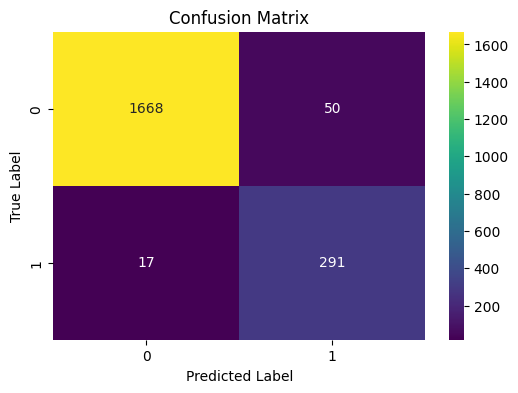

The roc_auc_score is  0.9927807931300365


In [54]:
# Get categorical feature indices
categorical_feature_indices = [X.columns.get_loc(col) for col in categorical_features]

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Step 2: Apply SMOTENC for oversampling
smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=47)
X_train_over, y_train_over = smote_nc.fit_resample(X_train, y_train)

# Step 3: Define preprocessor and model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Normalize numerical features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

gb_model = GradientBoostingClassifier(n_estimators=406,max_depth=3, min_samples_split=2, random_state=47)

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply the preprocessor
    ('Gradient Boosting Classifier', gb_model)  # model
])

pipeline.fit(X_train_over,y_train_over)
y_pred=pipeline.predict(X_test)
y_pred_proba=pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
plot_conf_matrix(pipeline,y_test,y_pred)
print("The roc_auc_score is ", roc_auc_score(y_test, y_pred_proba))

#### Comments on SMOTENC
The recall has improved, going from 0.92 to 0.94. The number of false negatives has also  decreased from 26 to 17, but the number of false positives increased from 31 to 50. 

# How do we chose the model? 
This is an open-ended question without a definitive answer. If the bank's top priority is to minimize false negatives at all costs, the Gradient Boosting Classifier with undersampling may be the best choice. It achieves the lowest number of false negatives (12) and an impressive recall of 0.96, along with a strong ROC AUC score of approximately 0.9916. While this approach does result in a higher number of false positives—rising from 31 to 81—this trade-off could be acceptable depending on the bank’s cost analysis of attrition. Ultimately, the decision should be based on a thorough evaluation of the financial implications of both false negatives and false positives.